<a href="https://colab.research.google.com/github/labilello/EA2-SOA/blob/master/HPC/Bilello_Leandro_ejercicio_2GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introducción
El ejemplo desarrollado en este notebook, rota una imágen parametrizada 180 grados. El calculo de la rotación para una imagen parametrizada siguiendo la logica:

**destino[anchoImg - 1 - x][altoImg - 1 - y] <- origen[x][y]**


Donde "x" refiere a una columna de la matriz e "y" refiere una fila de la misma.

# 2. Armado del Ambiente

Solicitamos al sistema la instalación de "pycuda", el modulo para python encargado de facilitar al programador el acceso a CUDA de Nvidia.

In [ ]:
!pip install pycuda

Para la ejecución, se requiere una imagen. Indique en el formulario la url de la misma y ejecute el modulo a continuación:

In [ ]:
#@title ### 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg

# 3. Desarrallo

A continuacion se encuentra el algoritmo de rotación de imágen para GPU. Ejecute el modulo a continuacion para ver los resultados.

Imagen del filtro: imagen.jpg -RGB- [768, 1024]
Thread: [ 16 , 19  ], Bloque : [ 48 , 54 ]
Total de Thread: [ 768 , 1026  ]  =  787968
Tiempo TOTAL:  63.414 [ms]
Tiempo GPU  :  0.231 [ms]


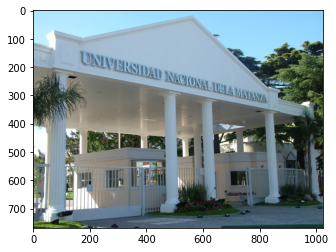

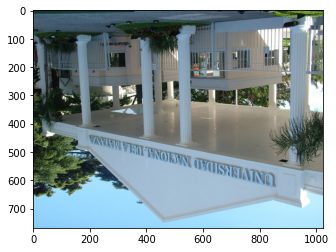

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.zeros_like( img_O_cpu )

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )


# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int x = threadIdx.x + blockIdx.x*blockDim.x;
  int y = threadIdx.y + blockIdx.y*blockDim.y;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( x < ancho && y < alto )
  {  
    // Escribo el color del pixel.
    img_R[ ( (ancho-1-x) + ( (alto-1-y)*ancho ) )*3      ] = img_O[ ( x + ( y*ancho ) ) * 3        ];
    img_R[ ( (ancho-1-x) + ( (alto-1-y)*ancho ) )*3 + 1  ] = img_O[ ( ( x + ( y*ancho ) ) * 3) + 1 ];
    img_R[ ( (ancho-1-x) + ( (alto-1-y)*ancho ) )*3 + 2  ] = img_O[ ( ( x + ( y*ancho ) ) * 3) + 2 ];
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" ) 

# 4. Tabla de Pasos

# 5. Conclusión

# 6. Bibliografía